# Invert Yellowstone Data

In [1]:
from simpeg import (maps, 
                    utils, 
                    data, 
                    optimization, 
                    regularization, 
                    inverse_problem, 
                    directives, 
                    inversion, 
                    data_misfit)
import discretize
from discretize.utils import mkvc, refine_tree_xyz
from simpeg.electromagnetics import natural_source as nsem
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Solver
from matplotlib.colors import LogNorm
from ipywidgets import interact, widgets
import warnings
from mtpy import MT, MTCollection

from pathlib import Path

import pandas as pd

warnings.filterwarnings("ignore", category=FutureWarning)

#https://docs.simpeg.xyz/latest/content/tutorials/01-models_mapping/plot_1_tensor_models.html



## Get Data from MTpy

In [2]:
interp_periods = np.logspace(np.log10(0.0032), np.log10(9.2), 20)

In [3]:
sdf = pd.read_pickle("data/sdf_20.pkl")


In [4]:
gdf = pd.read_pickle("data/gdf_20.pkl")

In [5]:
rx_loc = np.hstack(
    (mkvc(gdf.model_east.to_numpy(), 2), 
     mkvc(gdf.model_north.to_numpy(), 2),
     mkvc(gdf.model_elevation.to_numpy(),2))
     )
# --------------------> ELIMINAR
rx_loc

array([[ 4.12045544e+03, -3.37987784e+03,  2.09100000e+03],
       [-1.64600351e+03, -1.60006208e+03,  2.12500000e+03],
       [ 1.89832699e+03, -4.45755979e+03,  1.82000000e+03],
       [ 2.87272512e+03, -2.70486939e+03,  2.07000000e+03],
       [ 2.99410847e+03, -3.84495911e+03,  1.78700000e+03],
       [ 2.64629369e+03, -1.68749461e+03,  2.09800000e+03],
       [-2.73727067e+02, -3.32309439e+03,  1.81200000e+03],
       [ 5.04669346e+03, -2.71166453e+03,  2.22300000e+03],
       [ 1.64227182e+03, -2.74267883e+03,  2.18500000e+03],
       [-1.39142117e+03, -2.36556929e+03,  1.99400000e+03],
       [ 3.00491472e+02, -2.95540614e+03,  2.01200000e+03],
       [ 5.16011254e+03, -1.29546622e+03,  2.50500000e+03],
       [-1.00334947e+03,  2.55588635e+03,  2.26800000e+03],
       [ 5.90609858e+02, -1.05712197e+03,  2.40800000e+03],
       [-2.96357240e+03,  1.35192127e+03,  2.21700000e+03],
       [ 2.84109308e+01,  3.60483586e+03,  2.31200000e+03],
       [-3.78167179e+03,  4.20779111e+03

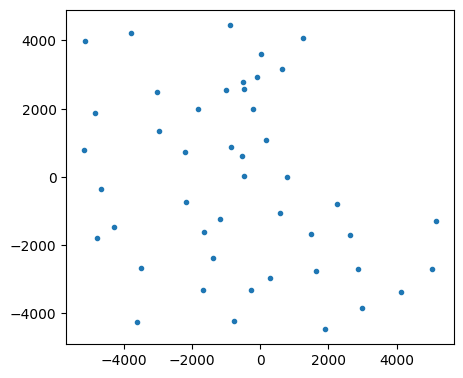

In [6]:
# --------------------> ELIMINAR
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(rx_loc[:, 0], rx_loc[:, 1], '.')
ax.set_aspect(1)

In [7]:
long_X = rx_loc[:,0].max()-rx_loc[:,0].min()
long_Y = rx_loc[:,1].max()-rx_loc[:,1].min()
long_Z_TM = 2879+3000
long_Z_TE = 2883.5+3000
#TM-->2879
#TE-->2883.5

#El área de modelamiento es 1.5 veces mayor que el área de interpretación
print(f"El área de modelamiento es X: {long_X*1.5}, Y: {long_Y*1.5}")
print(f"El padding corresponde a X: {long_X*.25}, Y: {long_Y*.25}")

El área de modelamiento es X: 15480.337630377326, Y: 13372.67936785816
El padding corresponde a X: 2580.0562717295543, Y: 2228.7798946430266


In [8]:
print(long_X/10, long_Y/10, long_Z_TM/10)

1032.0225086918217 891.5119578572106 587.9


# Mesh

In [9]:
from discretize import TensorMesh
from discretize.utils import active_from_xyz
from SimPEG.utils import mkvc, model_builder
from SimPEG import maps
from scipy.interpolate import Rbf

In [19]:
# Cargar el archivo .npy
#arrayTM = np.load("data/TM_10.npy")
arrayTE = np.load("data/TE_200_na.npy")

In [20]:
"""
array_TM = np.pad(
    arrayTM, 
    pad_width=((1, 1), (1, 1), (1, 0)),
    #mode = 'edge'
    mode='constant',                    
    constant_values=50       
)
"""
"""
array_TE = np.pad(
    arrayTE, 
    pad_width=((2, 2), (2, 2), (0, 2)),
    #mode = 'edge'
    mode='constant',             
    constant_values=50               
)
"""

"\narray_TE = np.pad(\n    arrayTE, \n    pad_width=((2, 2), (2, 2), (0, 2)),\n    #mode = 'edge'\n    mode='constant',             \n    constant_values=50               \n)\n"

In [21]:
#array_TM = arrayTM
array_TE = arrayTE

In [22]:
#res_data_TM = array_TM.flatten(order="F")
res_data_TE = array_TE.flatten(order="F")

## Mesh TM

In [37]:
def make_example_mesh():
    #hx = [(long_X/10, 10.0)]
    #hy = [(long_Y/10, 10.0)]
    #hz = [(long_Z_TM/10, 10.0)]

    #hx = [(long_X*.25/5,5,-1.1),(long_X/50, 50.0),(long_X*.25/5,5,1.1)]
    #hy = [(long_Y*.25/5,5,-1.1),(long_Y/50, 50.0),(long_Y*.25/5,5,1.1)]
    hx = [(long_X/30,2,-1),(long_X/30, 30.0),(long_X/30,2,1)]
    hy = [(long_Y/30,2,-1),(long_Y/30, 30.0),(long_Y/30,2,1)]
    hz = [(long_Z_TM/30, 30.0),(long_Z_TM/30,2,1)]

    origin = ["C","C",-3000]
    meshTM = TensorMesh([hx, hy, hz], origin)

    return meshTM

meshTM = make_example_mesh()

halfspace_value = 50.0

#Definir la topografía
[xx, yy] = np.meshgrid(meshTM.nodes_x, meshTM.nodes_y)

# Interpolación con RBF
rbf = Rbf(rx_loc[:,0], rx_loc[:,1], rx_loc[:,2],#-long_Z_TM+7000, 
          function='linear', epsilon=2)  #epsilon = suavidad

# Calcular los valores de altura en la malla
zz = rbf(xx.flatten(), yy.flatten())
zz = zz.reshape(xx.shape)

topo = np.c_[mkvc(xx), mkvc(yy), mkvc (zz)]

# Find cells below topography and define mapping
air_value = 0.0
ind_active = active_from_xyz(meshTM, topo, "CC")

model_map = maps.InjectActiveCells(meshTM, ind_active, air_value)

# Define the model
model = halfspace_value * np.ones(ind_active.sum())


In [38]:
dataTM_active = ind_active*res_data_TM
dataTM_active[dataTM_active == 0.0] = 1e-8

NameError: name 'res_data_TM' is not defined

In [16]:
halfspace_value = np.ones(meshTM.nC) * 1e-8
halfspace_value[ind_active] = 50.0

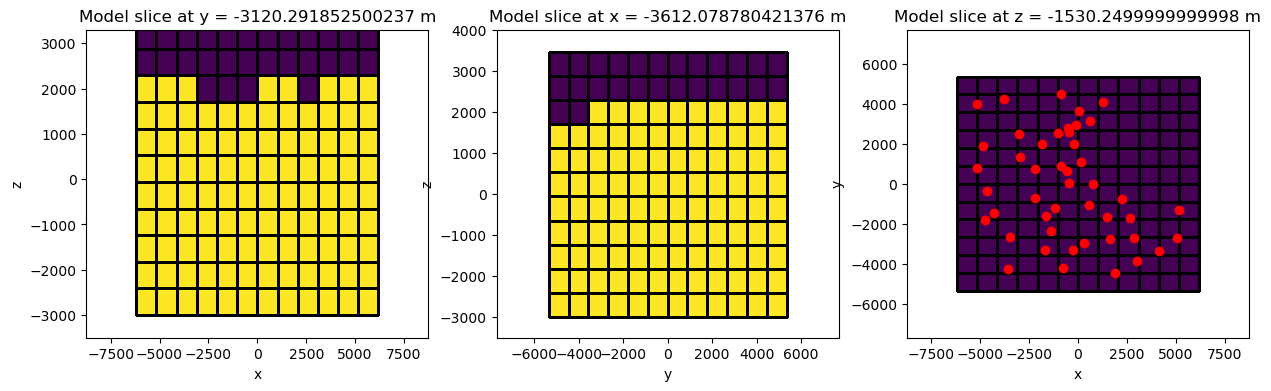

In [17]:
# --------------------------> ELIMINAR

# We can plot a slice of the model at Y=-2.5
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131)
#ind_slice = int(mesh2.shape_cells[1] / 2)

ind_slice = 2
meshTM.plot_slice(model_map * model, normal="Y", ax=ax, ind=ind_slice, grid=True,
                 #range_x=(rx_loc[:,0].min() - 700, rx_loc[:,0].max() + 700)
                 )
ax.set_title("Model slice at y = {} m".format(meshTM.cell_centers_y[ind_slice]))
ax.set_ylim(-3500, 3300)
ax.set_xlim(-1*(long_X*.75+1000), long_X*.75+1000)

ax = fig.add_subplot(132)
# 0 a 42
ind_slice = 2

meshTM.plot_slice(model_map * model, normal="X", ax=ax, ind=ind_slice, grid=True,
                 #range_x=(rx_loc[:,1].min() - 500, rx_loc[:,1].max() + 500)
                 )
ax.set_title("Model slice at x = {} m".format(meshTM.cell_centers_x[ind_slice]))
ax.set_ylim(-3500, 4000)
ax.set_xlim(-1*(long_Y*.75+1000), long_Y*.75+1000)

#2-24
ind_slice = 2
ax = fig.add_subplot(133)
#ind_slice = int(mesh2.shape_cells[1] / 2)
meshTM.plot_slice(model_map * model, 
                normal="Z", 
                ax=ax, 
                ind=ind_slice, 
                grid=True,
                #range_x=(rx_loc[:,0].min() - 700, rx_loc[:,0].max() + 700), 
                #range_y=(rx_loc[:,1].min() - 700, rx_loc[:,1].max() + 700)
                )
ax.set_xlim(-1*(long_X*.75+1000), long_X*.75+1000)
ax.set_ylim(-1*(long_Y*.75+1000), long_Y*.75+1000)

ax.plot(rx_loc[:,0], rx_loc[:,1], 'ro')
ax.set_title("Model slice at z = {} m".format(meshTM.cell_centers_z[ind_slice]))
plt.show()

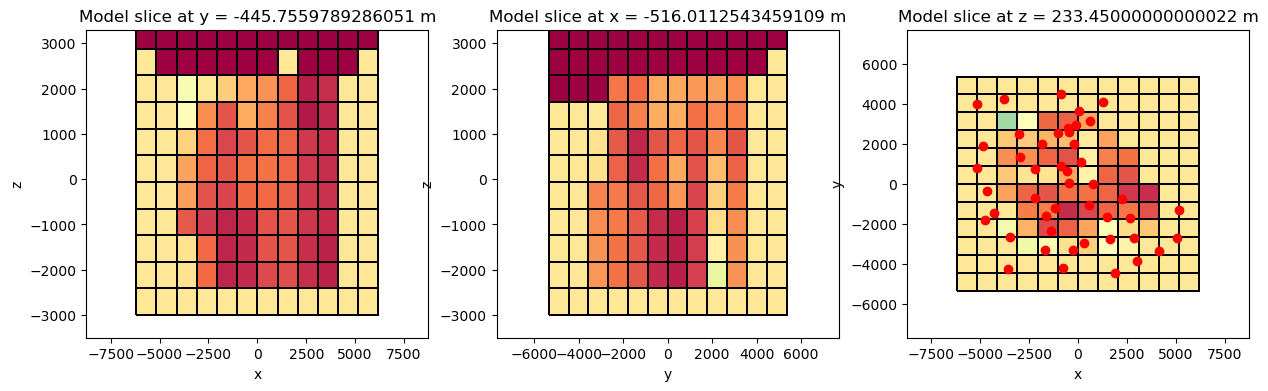

In [55]:
# --------------------------------> ELIMINAR

# We can plot a slice of the model at Y=-2.5
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131)
#ind_slice = int(mesh2.shape_cells[1] / 2)

ind_slice = 5
meshTM.plot_slice(dataTM_active, normal="Y", ax=ax, ind=ind_slice, grid=True,
                    pcolor_opts={"cmap":"Spectral", "norm":LogNorm(vmin=1e+0, vmax=1e+4)},
                    grid_opts={"lw":0.1, "color":'k'}, 
                 #range_x=(rx_loc[:,0].min() - 700, rx_loc[:,0].max() + 700)
                 )
ax.set_title("Model slice at y = {} m".format(meshTM.cell_centers_y[ind_slice]))
ax.set_ylim(-3500, 3300)
ax.set_xlim(-1*(long_X*.75+1000), long_X*.75+1000)


ax = fig.add_subplot(132)
# 0 a 42
ind_slice = 5

meshTM.plot_slice(dataTM_active, normal="X", ax=ax, ind=ind_slice, grid=True,
                pcolor_opts={"cmap":"Spectral", "norm":LogNorm(vmin=1e+0, vmax=1e+4)},
                grid_opts={"lw":0.1, "color":'k'}, 
                 #range_x=(rx_loc[:,1].min() - 500, rx_loc[:,1].max() + 500)
                 )
ax.set_title("Model slice at x = {} m".format(meshTM.cell_centers_x[ind_slice]))
ax.set_ylim(-3500, 3300)
ax.set_xlim(-1*(long_Y*.75+1000), long_Y*.75+1000)

#2-24
ind_slice = 5
ax = fig.add_subplot(133)
#ind_slice = int(mesh2.shape_cells[1] / 2)
meshTM.plot_slice(dataTM_active, 
                normal="Z", 
                ax=ax, 
                ind=ind_slice, 
                grid=True,
                pcolor_opts={"cmap":"Spectral", "norm":LogNorm(vmin=1e+0, vmax=1e+4)},
                grid_opts={"lw":0.1, "color":'k'}, 
                #range_x=(rx_loc[:,0].min() - 700, rx_loc[:,0].max() + 700), 
                #range_y=(rx_loc[:,1].min() - 700, rx_loc[:,1].max() + 700)
                )
ax.set_xlim(-1*(long_X*.75+1000), long_X*.75+1000)
ax.set_ylim(-1*(long_Y*.75+1000), long_Y*.75+1000)
ax.plot(rx_loc[:,0], rx_loc[:,1], 'ro')

ax.set_title("Model slice at z = {} m".format(meshTM.cell_centers_z[ind_slice]))
plt.show()

In [19]:
# -----------------> ELIMINAR
print(f"Number of cells: {meshTM.n_cells}")

Number of cells: 1584


## Mesh TE

In [23]:
def make_example_mesh():
    hx = [(long_X/200, 200.0)]
    hy = [(long_Y/200, 200.0)]
    hz = [(long_Z_TE/200, 200.0)]

    #hx = [(long_X*.25/5,5,-1.1),(long_X/50, 50.0),(long_X*.25/5,5,1.1)]
    #hy = [(long_Y*.25/5,5,-1.1),(long_Y/50, 50.0),(long_Y*.25/5,5,1.1)]
    #hx = [(long_X/15,2,-1),(long_X/15, 15.0),(long_X/15,2,1)]
    #hy = [(long_Y/15,2,-1),(long_Y/15, 15.0),(long_Y/15,2,1)]
    #hz = [(long_Z_TM/15, 15.0),(long_Z_TM/15,2,1)]

    origin = ["C","C",-3000]
    meshTE = TensorMesh([hx, hy, hz], origin)

    return meshTE

meshTE = make_example_mesh()

halfspace_value = 50.0

#Definir la topografía
[xx, yy] = np.meshgrid(meshTE.nodes_x, meshTE.nodes_y)

# Interpolación con RBF
rbf = Rbf(rx_loc[:,0], rx_loc[:,1], rx_loc[:,2],#-long_Z_TM+7000, 
          function='linear', epsilon=2)  #epsilon = suavidad

# Calcular los valores de altura en la malla
zz = rbf(xx.flatten(), yy.flatten())
zz = zz.reshape(xx.shape)

topo = np.c_[mkvc(xx), mkvc(yy), mkvc (zz)]

# Find cells below topography and define mapping
air_value = 0.0
ind_active = active_from_xyz(meshTE, topo, "CC")

model_map = maps.InjectActiveCells(meshTE, ind_active, air_value)

# Define the model
model = halfspace_value * np.ones(ind_active.sum())


In [24]:
dataTE_active = ind_active*res_data_TE
#dataTE_active[dataTE_active == "nan"] = 50.0
dataTE_active[dataTE_active == 0.0] = 1e-8
halfspace_value = np.ones(meshTE.nC) * 1e-8
halfspace_value[ind_active] = 50.0

In [25]:
dataTE_active

array([50., 50., 50., ..., 50., 50., 50.])

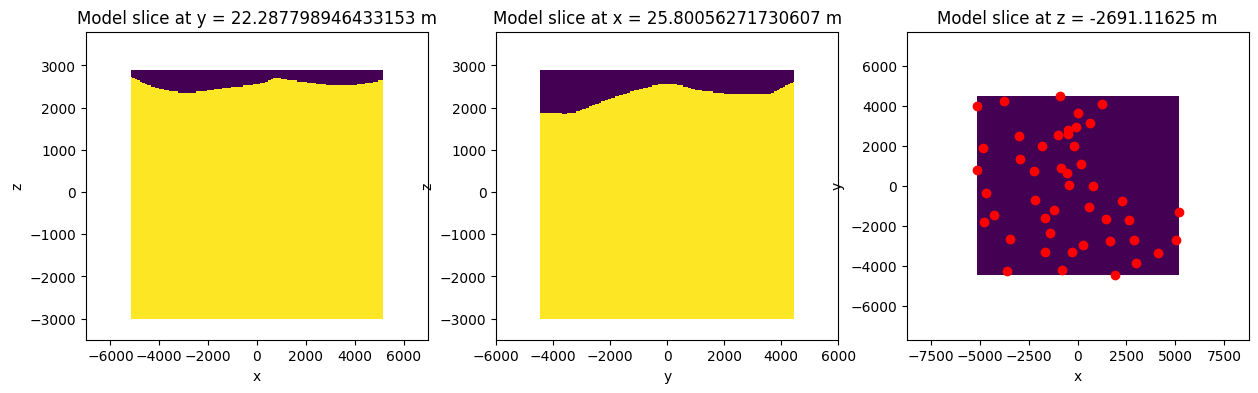

In [26]:
# --------------------------> ELIMINAR

# We can plot a slice of the model at Y=-2.5
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131)
#ind_slice = int(mesh2.shape_cells[1] / 2)

ind_slice = 100
meshTE.plot_slice(model_map * model, normal="Y", ax=ax, ind=ind_slice, grid=False,
                 #range_x=(rx_loc[:,0].min() - 700, rx_loc[:,0].max() + 700)
                 )
ax.set_title("Model slice at y = {} m".format(meshTE.cell_centers_y[ind_slice]))
ax.set_ylim(-3500, 3800)
#ax.set_xlim(-1*(long_X*.75+1000), long_X*.75+1000)
ax.set_xlim(-7000, 7000)


ax = fig.add_subplot(132)
# 0 a 42
ind_slice = 100

meshTE.plot_slice(model_map * model, normal="X", ax=ax, ind=ind_slice, grid=False,
                 #range_x=(rx_loc[:,1].min() - 500, rx_loc[:,1].max() + 500)
                 )
ax.set_title("Model slice at x = {} m".format(meshTE.cell_centers_x[ind_slice]))
ax.set_ylim(-3500, 3800)
#ax.set_xlim(-1*(long_Y*.75+1000), long_Y*.75+1000)
ax.set_xlim(-6000, 6000)

#2-24
ind_slice = 10
ax = fig.add_subplot(133)
#ind_slice = int(mesh2.shape_cells[1] / 2)
meshTE.plot_slice(model_map * model, 
                normal="Z", 
                ax=ax, 
                ind=ind_slice, 
                grid=False,
                #range_x=(rx_loc[:,0].min() - 700, rx_loc[:,0].max() + 700), 
                #range_y=(rx_loc[:,1].min() - 700, rx_loc[:,1].max() + 700)
                )
ax.set_xlim(-1*(long_X*.75+1000), long_X*.75+1000)
ax.set_ylim(-1*(long_Y*.75+1000), long_Y*.75+1000)

ax.plot(rx_loc[:,0], rx_loc[:,1], 'ro')
ax.set_title("Model slice at z = {} m".format(meshTE.cell_centers_z[ind_slice]))
plt.show()

In [27]:
dataTE_active

array([50., 50., 50., ..., 50., 50., 50.])

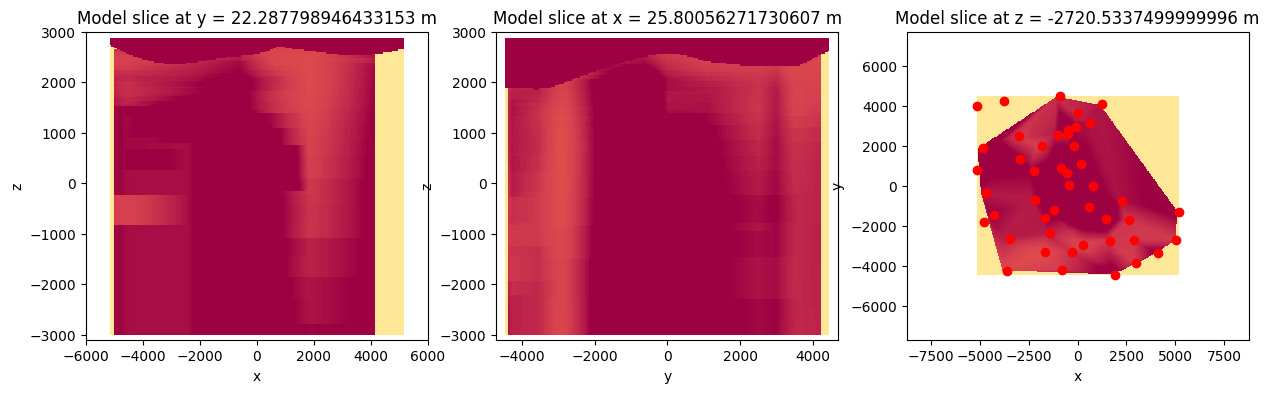

In [34]:
# --------------------------------> ELIMINAR

# We can plot a slice of the model at Y=-2.5
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131)
#ind_slice = int(mesh2.shape_cells[1] / 2)

ind_slice = 100
meshTE.plot_slice(dataTE_active, normal="Y", ax=ax, ind=ind_slice, grid=False,
                    pcolor_opts={"cmap":"Spectral", "norm":LogNorm(vmin=1e+0, vmax=1e+4)},
                    #grid_opts={"lw":0.1, "color":'k'}, 
                 #range_x=(rx_loc[:,0].min() - 700, rx_loc[:,0].max() + 700)
                 )
ax.set_title("Model slice at y = {} m".format(meshTE.cell_centers_y[ind_slice]))
ax.set_ylim(-3100, 3000)
#ax.set_xlim(-1*(long_X*.75), long_X*.75)
ax.set_xlim(-6000, 6000)


ax = fig.add_subplot(132)
# 0 a 42
ind_slice = 100

meshTE.plot_slice(dataTE_active, normal="X", ax=ax, ind=ind_slice, grid=False,
                pcolor_opts={"cmap":"Spectral", "norm":LogNorm(vmin=1e+0, vmax=1e+4)},
                #grid_opts={"lw":0.1, "color":'k'}, 
                 #range_x=(rx_loc[:,1].min() - 500, rx_loc[:,1].max() + 500)
                 )
ax.set_title("Model slice at x = {} m".format(meshTE.cell_centers_x[ind_slice]))
ax.set_ylim(-3100, 3000)
#ax.set_xlim(-1*(long_Y*.75+1000), long_Y*.75+1000)
ax.set_xlim(-4700, 4700)


#2-24
ind_slice = 9
ax = fig.add_subplot(133)
#ind_slice = int(mesh2.shape_cells[1] / 2)
meshTE.plot_slice(dataTE_active, 
                normal="Z", 
                ax=ax, 
                ind=ind_slice, 
                grid=False,
                pcolor_opts={"cmap":"Spectral", "norm":LogNorm(vmin=1e+0, vmax=1e+4)},
                #grid_opts={"lw":0.1, "color":'k'}, 
                #range_x=(rx_loc[:,0].min() - 700, rx_loc[:,0].max() + 700), 
                #range_y=(rx_loc[:,1].min() - 700, rx_loc[:,1].max() + 700)
                )
ax.set_xlim(-1*(long_X*.75+1000), long_X*.75+1000)
ax.set_ylim(-1*(long_Y*.75+1000), long_Y*.75+1000)
ax.plot(rx_loc[:,0], rx_loc[:,1], 'ro')

ax.set_title("Model slice at z = {} m".format(meshTE.cell_centers_z[ind_slice]))
plt.show()

(-6000.0, 6000.0)

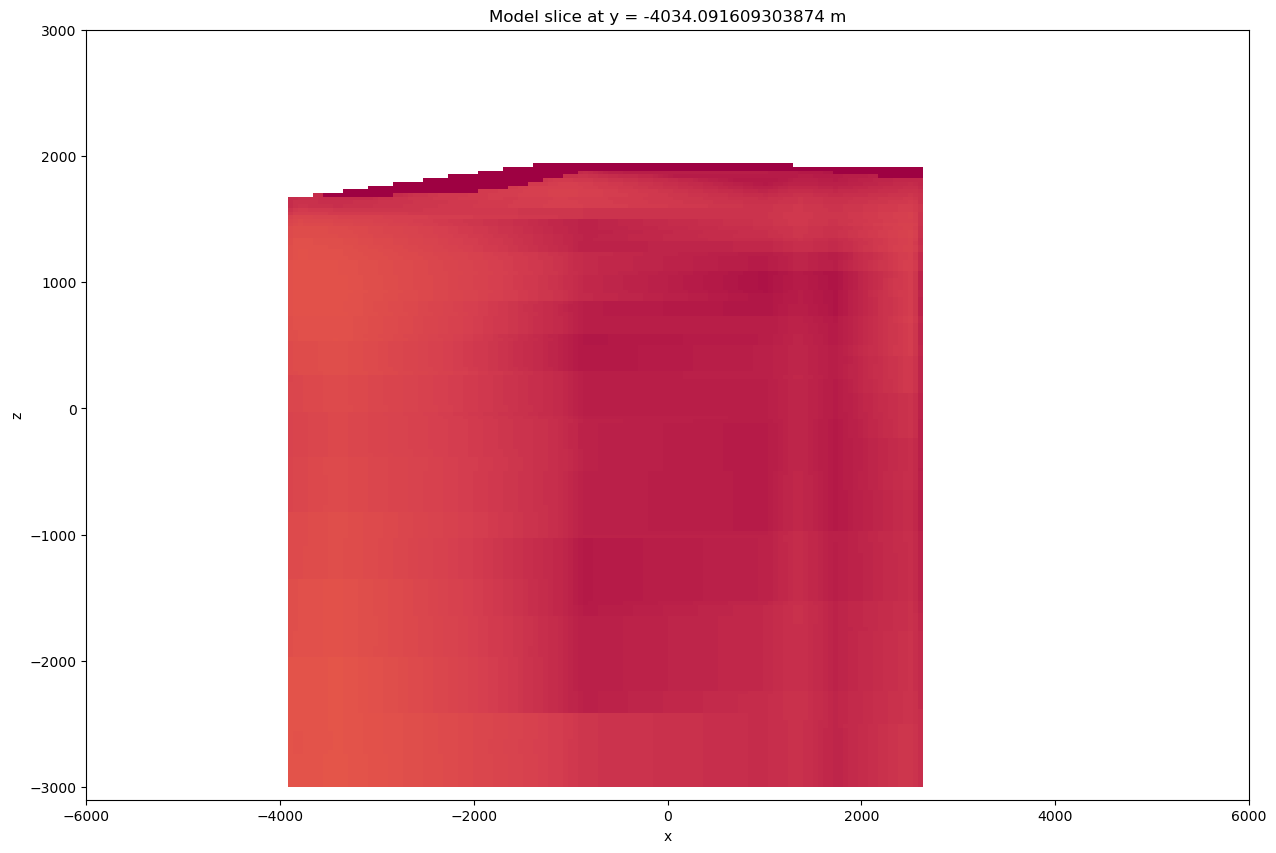

In [42]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
#ind_slice = int(mesh2.shape_cells[1] / 2)

ind_slice = 9
meshTE.plot_slice(dataTE_active, normal="Y", ax=ax, ind=ind_slice, grid=False,
                    pcolor_opts={"cmap":"Spectral", "norm":LogNorm(vmin=1e+0, vmax=1e+4)},
                    #grid_opts={"lw":0.1, "color":'k'}, 
                 #range_x=(rx_loc[:,0].min() - 700, rx_loc[:,0].max() + 700)
                 )
ax.set_title("Model slice at y = {} m".format(meshTE.cell_centers_y[ind_slice]))
ax.set_ylim(-3100, 3000)
#ax.set_xlim(-1*(long_X*.75), long_X*.75)
ax.set_xlim(-6000, 6000)

# Inversion

In [32]:
# Generate a Survey
rx_list = []
rx_orientations_impedance = ['xx', 'xy', 'yx', 'yy']
#components = ["zxx", "zxy", "zyx", "zyy", "tzx", "tzy"]

for rx_orientation in rx_orientations_impedance:    
    rx_list.append(     
        nsem.receivers.PointNaturalSource(
            rx_loc, orientation=rx_orientation, component="real"
        )
    )
    rx_list.append(
        nsem.receivers.PointNaturalSource(
            rx_loc, orientation=rx_orientation, component="imag"
        )
    )
rx_orientations_tipper = ['zx', 'zy']
for rx_orientation in rx_orientations_tipper:    
    rx_list.append(     
        nsem.receivers.Point3DTipper(
            rx_loc, orientation=rx_orientation, component="real"
        )
    )
    rx_list.append(
        nsem.receivers.Point3DTipper(
            rx_loc, orientation=rx_orientation, component="imag"
        )
    )
# Source list
src_list = [nsem.sources.PlanewaveXYPrimary(rx_list, frequency=f) for f in 1./interp_periods]


# Survey MT
survey = nsem.Survey(src_list)

In [33]:
rx_orientations = rx_orientations_impedance + rx_orientations_tipper

In [34]:
# -----------------------------> ELIMINAR
rx_list

In [35]:
frequencies = 1/interp_periods
components = ["zxx", "zxy", "zyx", "zyy", "tzx", "tzy"]
n_rx = rx_loc.shape[0]
n_freq = len(interp_periods)
n_component = 2
n_orientation = len(rx_orientations)

f_dict = dict([(round(ff, 5), ii) for ii, ff in enumerate(1/interp_periods)])
observations = np.zeros((n_freq, n_orientation, n_component, n_rx))
errors = np.zeros_like(observations)
for s_index, station in enumerate(gdf.station):
    station_df = sdf.loc[sdf.station == station]
    station_df.set_index("period", inplace=True)
    for row in station_df.itertuples():
        f_index = f_dict[round(1./row.Index, 5)]
        for c_index, comp in enumerate(components):
            value = getattr(row, comp)
            err = getattr(row, f"{comp}_model_error")
            observations[f_index, c_index, 0, s_index] = value.real
            observations[f_index, c_index, 1, s_index] = value.imag
            errors[f_index, c_index, 0, s_index] = err
            errors[f_index, c_index, 1, s_index] = err
        

In [36]:
observations[np.where(observations == 0)] = 100
errors[np.where(errors == 0)] = np.inf

In [37]:
# ---------------------> ELIMINAR
observations.shape

(30, 6, 2, 46)

In [38]:
# ---------------------> ELIMINAR
def foo_data(i_freq, i_orientation, i_component):
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    vmin = np.min([observations[i_freq, i_orientation, i_component,:].min()])
    vmax = np.max([observations[i_freq, i_orientation, i_component,:].max()])
    out1 = utils.plot2Ddata(rx_loc, observations[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax, contourOpts={'cmap':'turbo'}, ncontour=20)
    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')
    if i_orientation<4:
        transfer_type = "Z"
    else:
        transfer_type = "T"
    if i_component == 0:
        comp = "real"
    else:
        comp = "imag"
    ax.set_title(f"Frequency={1./interp_periods[i_freq]:.1e}, {transfer_type:s}{rx_orientations[i_orientation]:s}-{comp:s}")

In [39]:
# ---------------------> ELIMINAR
interact(
    foo_data,
    i_freq=widgets.IntSlider(min=0, max=n_freq-1),
    i_orientation=widgets.IntSlider(min=0, max=n_component-1), 
    i_component=widgets.IntSlider(min=0, max=n_orientation-1), 
)

interactive(children=(IntSlider(value=0, description='i_freq', max=29), IntSlider(value=0, description='i_orie…

<function __main__.foo_data(i_freq, i_orientation, i_component)>

In [40]:
# Assign uncertainties
# make data object
data_object = data.Data(survey, dobs=observations.flatten(), standard_deviation=errors.flatten())

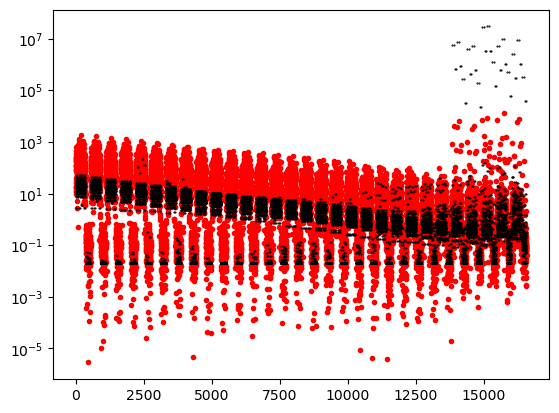

In [41]:
# ---------------------> ELIMINAR

# data_object.standard_deviation = stdnew.flatten()  # sim.survey.std
plt.semilogy(abs(data_object.dobs), '.r')
plt.semilogy((data_object.standard_deviation), 'k.', ms=1)
plt.show()

## Inversion TM

In [61]:
#%%time
# Set the mapping
active_map = maps.InjectActiveCells(
    mesh=meshTM, indActive=ind_active, valInactive=np.log(1e-8)
)
mapping = maps.ExpMap(meshTM) * active_map

# True model 
m_true = np.log(halfspace_value[ind_active])

# Setup the problem object
simulation = nsem.simulation.Simulation3DPrimarySecondary(
    meshTM,
    survey=survey,
    sigmaMap=mapping,
    sigmaPrimary=halfspace_value,
    solver=Solver

)
dpred = simulation.dpred(m_true)

In [ ]:
%%time

# Optimization
opt = optimization.ProjectedGNCG(maxIter=10, maxIterCG=20, upper=np.inf, lower=-np.inf)
opt.remember('xc')
# Data misfit
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)
# Regularization
dz = mesh2.h[2].min()
dx = mesh2.h[0].min()
regmap = maps.IdentityMap(nP=int(ind_active.sum()))
reg = regularization.Sparse(mesh2, indActive=ind_active, mapping=regmap)
reg.alpha_s = 1e-5
reg.alpha_x = dz/dx
reg.alpha_y = dz/dx
reg.alpha_z = 1.

# Inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
# Beta schedule
beta = directives.BetaSchedule(coolingRate=1, coolingFactor=2)
# Initial estimate of beta
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# Target misfit stop
target = directives.TargetMisfit()
# Create an inversion object
save_dictionary = directives.SaveOutputDictEveryIteration()
directive_list = [beta, beta_est, target, save_dictionary]
inv = inversion.BaseInversion(inv_prob, directiveList=directive_list)

# Set an intitial guess
m_0 = np.log(dataTM_active[ind_active])


In [ ]:
%%time
mopt = inv.run(m_0)

In [ ]:
import pickle

# Diccionario que quieres guardar
out_dict = save_dictionary.outDict  # Asumiendo que este es tu diccionario

# Guardar el diccionario en un archivo
with open("Data_Inversion_TM.pkl", "wb") as file:
    pickle.dump(out_dict, file)

## Inversion TE

In [43]:
#%%time
# Set the mapping
active_map = maps.InjectActiveCells(
    mesh=meshTE, indActive=ind_active, valInactive=np.log(1e-8)
)
mapping = maps.ExpMap(meshTE) * active_map

# True model 
m_true = np.log(halfspace_value[ind_active])

# Setup the problem object
simulation = nsem.simulation.Simulation3DPrimarySecondary(
    meshTE,
    survey=survey,
    sigmaMap=mapping,
    sigmaPrimary=halfspace_value,
    solver=Solver

)
#dpred = simulation.dpred(m_true)

In [ ]:
#%%time

# Optimization
opt = optimization.ProjectedGNCG(maxIter=50, maxIterCG=20, upper=np.inf, lower=-np.inf)
opt.remember('xc')
# Data misfit
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)
# Regularization
dz = meshTE.h[2].min()
dx = meshTE.h[0].min()
regmap = maps.IdentityMap(nP=int(ind_active.sum()))
reg = regularization.Sparse(meshTE, indActive=ind_active, mapping=regmap)
reg.alpha_s = 1e-6
reg.alpha_x = dz/dx
reg.alpha_y = dz/dx
reg.alpha_z = 1.

# Inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
# Beta schedule
beta = directives.BetaSchedule(coolingRate=1, coolingFactor=3)
# Initial estimate of beta
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# Target misfit stop
target = directives.TargetMisfit()
# Create an inversion object
save_dictionary = directives.SaveOutputDictEveryIteration()
directive_list = [beta, beta_est, target, save_dictionary]
inv = inversion.BaseInversion(inv_prob, directiveList=directive_list)

# Set an intitial guess
m_0 = np.log(dataTE_active[ind_active])


In [47]:
target.target

8280.0

In [ ]:
%%time
mopt = inv.run(m_0)

# Graficar

In [ ]:
import pickle

# Diccionario que quieres guardar
out_dict = save_dictionary.outDict  # Asumiendo que este es tu diccionario

# Guardar el diccionario en un archivo
with open("Data_Inversion_TM.pkl", "wb") as file:
    pickle.dump(out_dict, file)

In [33]:
import pickle
with open("output/Inversion_TM.pkl", "rb") as archivo:
    dictionary = pickle.load(archivo)

NameError: name 'inv_prob' is not defined

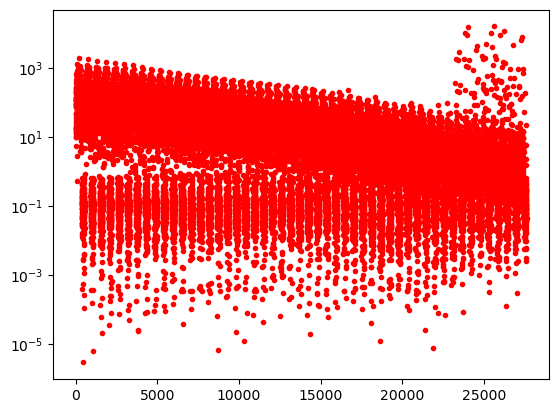

In [32]:
# data_object.standard_deviation = stdnew.flatten()  # sim.survey.std
plt.semilogy(abs(data_object.dobs), '.r')
plt.semilogy(abs(inv_prob.dpred), 'k.', ms=1)
plt.semilogy(abs(data_object.standard_deviation), 'b.', ms=1)
plt.show()

In [65]:
iteration = len(dictionary)
m = dictionary[iteration]['m']
sigma_est = mapping*m
pred = dictionary[iteration]['dpred']
DPRED = pred.reshape((n_freq, n_orientation, n_component, n_rx))
DOBS = dpred.reshape((n_freq, n_orientation, n_component, n_rx))
#MISFIT = (DPRED-DOBS)/STD

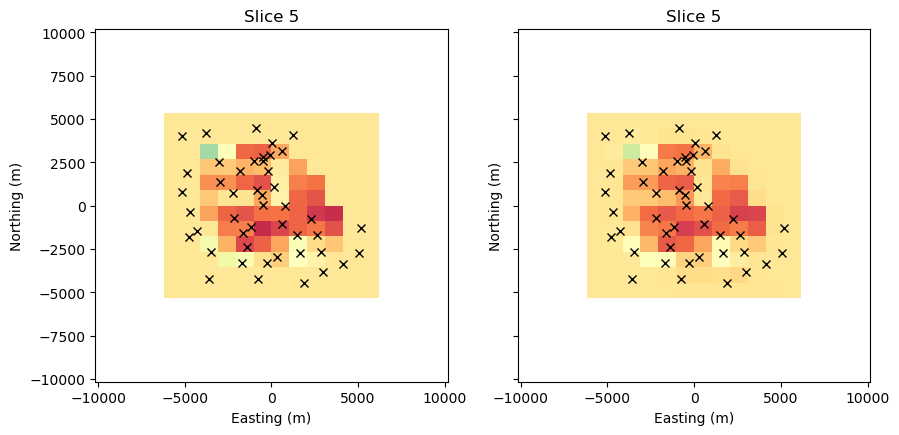

In [56]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
ind_slice = 5
meshTM.plot_slice(
    dataTM_active, grid=False, normal='Z', ax=ax1,
    pcolor_opts={"cmap":"Spectral", "norm":LogNorm(vmin=1e+0, vmax=1e+4)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    #slice_loc=z_loc
    ind = ind_slice
)
meshTM.plot_slice(
    sigma_est, grid=False, normal='Z', ax=ax2,
    pcolor_opts={"cmap":"Spectral", "norm":LogNorm(vmin=1e+0, vmax=1e+4)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    #slice_loc=z_loc
    ind = ind_slice
)
ax2.set_yticklabels([])
for ax in axs:
    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")

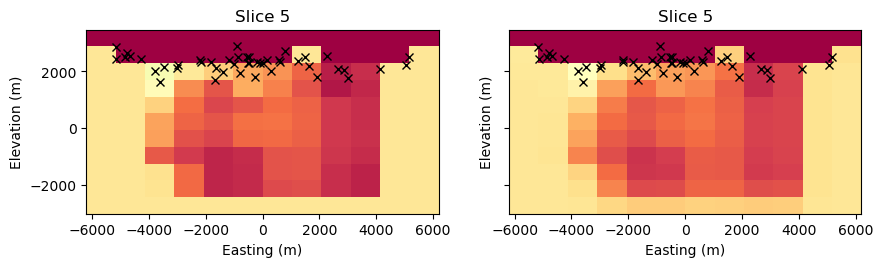

In [57]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
lx_core = rx_loc[:,0].max() - rx_loc[:,0].min()

ind_slice = 5
meshTM.plot_slice(
    dataTM_active, grid=False, normal='Y', ax=ax1,
    pcolor_opts={"cmap":"Spectral", "norm":LogNorm(vmin=1e+0, vmax=1e+4)},
    #range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    #range_y=(-lx_core, lx_core*0.1),
    #slice_loc=y_loc
    ind = ind_slice
)
ax.set_ylim(-3500, 3300)
ax.set_xlim(-1*(long_X*.75+1000), long_X*.75+1000)
meshTM.plot_slice(
    sigma_est, grid=False, normal='Y', ax=ax2,
    pcolor_opts={"cmap":"Spectral", "norm":LogNorm(vmin=1e+0, vmax=1e+4)},
    #range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    #range_y=(-lx_core, lx_core*0.1),
    #slice_loc=y_loc
    ind = ind_slice
)
ax.set_ylim(-3500, 3300)
ax.set_xlim(-1*(long_X*.75+1000), long_X*.75+1000)
ax2.set_yticklabels([])
for ax in axs:
    ax.plot(rx_loc[:,0], rx_loc[:,2], 'kx')
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Elevation (m)")


In [ ]:
from ipywidgets import interact, widgets

In [63]:
def foo_misfit(i_freq, i_orientation, i_component):
    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    ax1, ax2, ax3 = axs

    vmin = np.min([DOBS[i_freq, i_orientation, i_component,:].min(), DPRED[i_freq, i_orientation, i_component,:].min()])
    vmax = np.max([DOBS[i_freq, i_orientation, i_component,:].max(), DPRED[i_freq, i_orientation, i_component,:].max()])

    out1 = utils.plot2Ddata(rx_loc, DOBS[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax1, contourOpts={'cmap':'turbo'}, ncontour=20)
    out2 = utils.plot2Ddata(rx_loc, DPRED[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax2, contourOpts={'cmap':'turbo'}, ncontour=20)
    #out3 = utils.plot2Ddata(rx_loc, MISFIT[i_freq, i_orientation, i_component,:], clim=(-5, 5), ax=ax3, contourOpts={'cmap':'turbo'}, ncontour=20)

    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')

In [66]:
interact(
    foo_misfit,
    i_freq=widgets.IntSlider(min=0, max=n_freq-1),
    i_orientation=widgets.IntSlider(min=0, max=n_orientation-1), 
    i_component=widgets.IntSlider(min=0, max=n_component-1), 
)

interactive(children=(IntSlider(value=0, description='i_freq', max=49), IntSlider(value=0, description='i_orie…

<function __main__.foo_misfit(i_freq, i_orientation, i_component)>

In [ ]:
models = {}
models["estimated_sigma"] = sigma_est
models['true_sigma'] = sigma
mesh.write_vtk("mt_synthetic",models=models)

In [ ]:
mc.close_collection()